In [ ]:
# Preparing labels datasets

import pandas as pd
import os

def get_data_labels(path_files, path_labels):
    data = pd.read_csv(path_files, sep=',')
    

    nii_list = pd.read_csv(path_labels, sep = ";", header=None)
    nii_list.rename(columns={0:"subject", 1:"file"}, inplace = True)
   
    nii_files = list(nii_list["file"])

    data_labels = pd.DataFrame()
    not_found = []

    for file in nii_files:
        subject = pd.DataFrame()
        idx = [i for i in range(len(file)) if file[i] == '_']

        PTID = file[idx[0]+1:idx[3]]
        SeriesID = int(file[idx[-2]+2:idx[-1]])
        ImageID = int(file[idx[-1]+2:-4])
        
        subject = data[["PTID", "Series.ID", "Image.ID", "Screen.Diagnosis"]][(data["PTID"] == PTID) & (data["Series.ID"] == SeriesID) & (data["Image.ID"] == ImageID)]
        if len(subject) == 0:
            not_found.append(file)
            continue
        subject["Subject.ID"] = nii_list["subject"][nii_list["file"] == file].values[0]
        subject["Nii.File"] = file
        
        data_labels = pd.concat([data_labels, subject])

    return data_labels, not_found

base_dir = "C:/Users/Usuario/Documents/TFM - Chey/"

path_files =  os.path.join(base_dir, "ADNI_Complete1YearVisitList_3T_8_28_12.csv")
path_labels = os.path.join(base_dir, "adni_nii_files_list.txt")
data_labels_1, not_found_1 = get_data_labels(path_files, path_labels)

path_files = os.path.join(base_dir, "ADNI_CompleteAnnual2YearVisitList_3T_8_28_12.csv")
path_labels = os.path.join(base_dir, "adni_nii_files_list2.txt")
data_labels_2, not_found_2 = get_data_labels(path_files, path_labels)

path_files = os.path.join(base_dir,"ADNI_CompleteVisitList_3T_8_28_12.csv")
path_labels = os.path.join(base_dir, "adni_nii_files_list3.txt")
data_labels_3, not_found_3 = get_data_labels(path_files, path_labels)

In [12]:
data_labels_3["Screen.Diagnosis"].unique()

array(['NL', 'MCI', 'AD'], dtype=object)

In [3]:
data_labels_3["Subject.ID"].isnull().sum()

np.int64(0)

## CNN

In [5]:
# Imports
import os
import pandas as pd
import numpy as np
import nibabel as nib
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from nibabel import processing
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical

##### Loading de data

In [6]:
# FUNCTIONS
# Defining path files
def loading_data(path, orig = False):
    nii_path = ""
    for file in sorted(os.listdir(path)):
        if file.endswith(".nii"):
            nii_path = os.path.join(path, file)
    left_path = os.path.join(path, "hippocampal_sections","left_hippocampus.mgz")
    right_path = os.path.join(path, "hippocampal_sections", "right_hippocampus.mgz")

    # Loading files
    nii_img = nib.load(nii_path)
    left = nib.load(left_path)
    right = nib.load(right_path)

    # Checking if images need rotation
    if tuple(nib.aff2axcodes(nii_img.affine)) != ('I', 'P', 'L'):
        nii_img = rotation(nii_img, "nii")
        left = rotation(left, "mgz")
        right = rotation(right, "mgz")


    # Resampling the files
    left = processing.resample_from_to(left, nii_img, order = 0)
    right = processing.resample_from_to(right, nii_img, order = 0)

    # getting the arrays arrays
    nii_data = nii_img.get_fdata()
    left_data = left.get_fdata()
    right_data = right.get_fdata()

    if orig:
        return(nii_img, left, right, nii_data, left_data, right_data)
    else:
        return(nii_data, left_data, right_data)

# Calculating coords
def global_coord(mask_data):
    mask = np.argwhere(mask_data == 1)
    min_values = mask.min(axis=0)
    max_values = mask.max(axis=0)
    
    center_coord = (max_values + min_values) // 2

    max_dist = (max_values - min_values).max()
    total_dist = (max_dist + 2*10) // 2 # adding the 10 voxel margin and computing the distance from the center to the side on the box
 
    min_coord = center_coord - total_dist
    max_coord = center_coord + total_dist

    return (min_coord, max_coord)

# Getting the bounding box dimensions
def bounding_box(data, mask_left, mask_right, min_global_coord_l, max_global_coord_l, min_global_coord_r, max_global_coord_r):
    center_l = (max_global_coord_l + min_global_coord_l) // 2
    center_r = (max_global_coord_r + min_global_coord_r) // 2

    max_dist_l = max_global_coord_l - center_l
    min_dist_l = center_l - min_global_coord_l
    max_dist_r = max_global_coord_r - center_r
    min_dist_r = center_r - min_global_coord_r

    max_dist = np.max([max_dist_l, max_dist_r],axis = 0)
    min_dist = np.min([min_dist_l, min_dist_r], axis = 0)

    max_coord_l = center_l + max_dist
    min_coord_l = center_l - min_dist
    max_coord_r = center_r + max_dist
    min_coord_r = center_r - min_dist

    # Getting the cropped MRI
    cropped_data_l = data[min_coord_l[0]:max_coord_l[0], min_coord_l[1]:max_coord_l[1], min_coord_l[2]:max_coord_l[2]]
    cropped_data_r = data[min_coord_r[0]:max_coord_r[0], min_coord_r[1]:max_coord_r[1], min_coord_r[2]:max_coord_r[2]]
    cropped_mask_l = mask_left[min_coord_l[0]:max_coord_l[0], min_coord_l[1]:max_coord_l[1], min_coord_l[2]:max_coord_l[2]]
    cropped_mask_r = mask_right[min_coord_r[0]:max_coord_r[0], min_coord_r[1]:max_coord_r[1], min_coord_r[2]:max_coord_r[2]]
    return(cropped_data_l, cropped_data_r, cropped_mask_l.astype(np.int32), cropped_mask_r.astype(np.int32), min_coord_l, min_coord_r)

# Calculating the new affine
def new_aff (nii_img, new_coord):
    M = nii_img.affine[:3,:3]
    abc = nii_img.affine[:3,3]
    new = nii_img.affine.copy()
    translation = new_coord
    new[:3,3] = np.dot(M,translation) + abc
    return(new)

# Getting max and min coordinates
def coord(init_dir):
    min_coord_tmp_l = []
    max_coord_tmp_l = []
    min_coord_tmp_r = []
    max_coord_tmp_r = []

    files={}

    for folder in sorted(os.listdir(init_dir)):
        path = os.path.join(init_dir, folder)
        print("Getting coordinates from: ", folder)
        print("---------------------")
        nii_data, left_data, right_data = loading_data(path)
        min_coord_l, max_coord_l = global_coord(left_data)
        min_coord_r, max_coord_r = global_coord(right_data)

        min_coord_tmp_l.append(min_coord_l)
        max_coord_tmp_l.append(max_coord_l)
        min_coord_tmp_r.append(min_coord_r)
        max_coord_tmp_r.append(max_coord_r)

        files[folder] = [min_coord_l, max_coord_l, min_coord_r, max_coord_r]

    min_global_coord_l = np.min(min_coord_tmp_l, axis=0)
    max_global_coord_l = np.max(max_coord_tmp_l, axis=0)
    min_global_coord_r = np.min(min_coord_tmp_r, axis=0)
    max_global_coord_r = np.max(max_coord_tmp_r, axis=0)

    return(min_global_coord_l, max_global_coord_l, min_global_coord_r, max_global_coord_r) 

def crop(init_dir, output_dir, min_l, max_l, min_r, max_r):
    for folder in sorted(os.listdir(init_dir)):
        path = os.path.join(init_dir, folder)
        output_dir_crop = os.path.join(output_dir,folder,"cropped")
        print("Cropping MRI from ", folder)
        print("---------------------")
        nii_img, left, right, nii_data, left_data, right_data = loading_data(path, True)
        cropped_nii_l, cropped_nii_r, cropped_mask_l, cropped_mask_r, min_coord_l, min_coord_r = bounding_box(nii_data, left_data, right_data, min_l, max_l, min_r, max_r) 
        # Defining new affines
        new_nii_aff_l = new_aff(nii_img, min_coord_l)
        new_nii_aff_r = new_aff(nii_img, min_coord_r)
        new_mask_aff_l = new_aff(left, min_coord_l)
        new_mask_aff_r = new_aff(right, min_coord_r)

        # Transforming the arrays to nibabel objects
        cropped_nii_l = nib.Nifti1Image(cropped_nii_l, affine = new_nii_aff_l) # nii format image
        cropped_nii_r = nib.Nifti1Image(cropped_nii_r, affine = new_nii_aff_r)
        cropped_mask_l = nib.MGHImage(cropped_mask_l, affine = new_mask_aff_l) # mgh and mgz format image
        cropped_mask_r = nib.MGHImage(cropped_mask_r, affine = new_mask_aff_r) 

        # Saving the images in its appropiate format
        os.makedirs(output_dir_crop, exist_ok=True) # Creation of the directory for the corpped images
        nib.save(cropped_nii_l, os.path.join(output_dir_crop,"cropped_nii_left.nii"))
        nib.save(cropped_nii_r, os.path.join(output_dir_crop,"cropped_nii_right.nii"))
        nib.save(cropped_mask_l, os.path.join(output_dir_crop,"cropped_mask_left.mgz"))
        nib.save(cropped_mask_r, os.path.join(output_dir_crop,"cropped_mask_right.mgz"))         

        # Cleaning variables for the next iteration
        del cropped_nii_l, cropped_mask_l, min_coord_l, cropped_nii_r, cropped_mask_r, min_coord_r, new_nii_aff_l, new_nii_aff_r, new_mask_aff_l, new_mask_aff_r
        gc.collect()

def rotation(img, type):
    org_orient = nib.orientations.io_orientation(img.affine)
    target_orient = nib.orientations.axcodes2ornt(('I', 'P', 'L'))

    transform = nib.orientations.ornt_transform(org_orient, target_orient)

    # Reorientar los datos
    reoriented_data = nib.apply_orientation(img.get_fdata(), transform)

    # Corregir la affine
    new_affine = np.matmul(img.affine, nib.orientations.inv_ornt_aff(transform, img.shape))

    if(type == "nii"):
        return nib.Nifti1Image(reoriented_data, affine = new_affine)
    if(type == "mgz"):
        return nib.MGHImage(reoriented_data.astype(np.int32), affine = new_affine)

In [58]:
min_l1, max_l1, min_r1, max_r1 = coord("E:/ADNI1_Complete 1Yr 3T - processed")
min_l2, max_l2, min_r2, max_r2 = coord("E:/ADNI1_Annual 2 Yr 3T - processed")
min_l3, max_l3, min_r3, max_r3 = coord("E:/ADNI1_Complete 3Yr 3T - processed")

min_l = np.min([min_l1, min_l2, min_l3], axis=0)
max_l = np.max([max_l1, max_l2, max_l3], axis=0)
min_r = np.min([min_r1, min_r2, min_r3], axis=0)
max_r = np.max([max_r1, max_r2, max_r3], axis=0)




Getting coordinates from:  subject1
---------------------
Getting coordinates from:  subject10
---------------------
Getting coordinates from:  subject100
---------------------
Getting coordinates from:  subject101
---------------------
Getting coordinates from:  subject102
---------------------
Getting coordinates from:  subject103
---------------------
Getting coordinates from:  subject104
---------------------
Getting coordinates from:  subject105
---------------------
Getting coordinates from:  subject106
---------------------
Getting coordinates from:  subject107
---------------------
Getting coordinates from:  subject108
---------------------
Getting coordinates from:  subject109
---------------------
Getting coordinates from:  subject11
---------------------
Getting coordinates from:  subject110
---------------------
Getting coordinates from:  subject111
---------------------
Getting coordinates from:  subject112
---------------------
Getting coordinates from:  subject113
------

In [10]:
crop("E:/ADNI1_Complete 1Yr 3T - processed", "E:/ADNI1_Complete 1Yr 3T - processed",min_l, max_l, min_r, max_r)
crop("E:/ADNI1_Annual 2 Yr 3T - processed", "E:/ADNI1_Annual 2 Yr 3T - processed",min_l, max_l, min_r, max_r)
crop("E:/ADNI1_Complete 3Yr 3T - processed", "E:/ADNI1_Complete 3Yr 3T - processed",min_l, max_l, min_r, max_r)

Cropping MRI from  subject1
---------------------
Cropping MRI from  subject10
---------------------
Cropping MRI from  subject100
---------------------
Cropping MRI from  subject101
---------------------
Cropping MRI from  subject102
---------------------
Cropping MRI from  subject103
---------------------
Cropping MRI from  subject104
---------------------
Cropping MRI from  subject105
---------------------
Cropping MRI from  subject106
---------------------
Cropping MRI from  subject107
---------------------
Cropping MRI from  subject108
---------------------
Cropping MRI from  subject109
---------------------
Cropping MRI from  subject11
---------------------
Cropping MRI from  subject110
---------------------
Cropping MRI from  subject111
---------------------
Cropping MRI from  subject112
---------------------
Cropping MRI from  subject113
---------------------
Cropping MRI from  subject114
---------------------
Cropping MRI from  subject115
---------------------
Cropping MRI fro

##### Uploading crops

In [ ]:
def X_y_datasets(init_dir, data_labels, type="normal"):
    X = []
    y = []

    no_label = {} # Dictionary with subjects without diagnosis
    cont = 0

    for dir in init_dir:
        
        for folder in os.listdir(dir):
            path = os.path.join(dir, folder)
            for file in os.listdir(path):
                if file.startswith("ADNI") and file.endswith(".nii"):
                    nii_name = file
            path = os.path.join(dir, folder, "cropped")
            left_path = os.path.join(path, "cropped_nii_left.nii")
            right_path = os.path.join(path, "cropped_nii_right.nii")

            left_nii = nib.load(left_path).get_fdata()
            right_nii = nib.load(right_path).get_fdata()
            
            if(type == "flipped"):
                right_nii_flipped = np.flip(right_nii, axis=1)
                right_nii_flipped = right_nii_flipped[...,np.newaxis]

            if(type == "whole"):
                whole_hippomcapus = np.concatenate([left_nii, right_nii], axis = 2) # Concatenate sides by width
                whole_hippomcapus = whole_hippomcapus[..., np.newaxis]

            left_nii = left_nii[...,np.newaxis]
            right_nii = right_nii[...,np.newaxis]

            if(type == "channel"):
                channels_hippomcapus = np.concatenate([left_nii, right_nii], axis = -1) # Concatenate sides by channel

            diagnosis = data_labels[cont]["Screen.Diagnosis"][data_labels[cont]["Nii.File"] == nii_name]

            if len(diagnosis) > 0:
                if(type == "normal"):
                    X.append(left_nii)
                    y.append(diagnosis.values[0])
                    X.append(right_nii)
                    y.append(diagnosis.values[0])

                elif(type == "flipped"):
                    X.append(left_nii)
                    y.append(diagnosis.values[0])
                    X.append(right_nii_flipped)
                    y.append(diagnosis.values[0])

                elif(type == "channel"):
                    X.append(channels_hippomcapus)
                    y.append(diagnosis.values[0])

                elif(type == "whole"):
                    X.append(whole_hippomcapus)
                    y.append(diagnosis.values[0])
            else:
                no_label[folder] = nii_name
        cont += 1   
    if (type == "normal"):
        return X, y, no_label
    else:
        return X, y

In [ ]:
init_dir = ["E:/ADNI1_Complete 1Yr 3T - processed", "E:/ADNI1_Annual 2 Yr 3T - processed", "E:/ADNI1_Complete 3Yr 3T - processed"]

X, y, no_label = X_y_datasets(init_dir, [data_labels_1, data_labels_2, data_labels_3])
# X_flipped, y_flipped = X_y_datasets(init_dir, [data_labels_1, data_labels_2, data_labels_3], flipped)
# X_channels, y_channels = X_y_datasets(init_dir, [data_labels_1, data_labels_2, data_labels_3], channel)
# X_whole, y_whole = X_y_datasets(init_dir, [data_labels_1, data_labels_2, data_labels_3], whole)

In [ ]:
# Checking whether all corps have the same dimensions

count_x = 0
idx_x = []
count_y = 0
idx_y = []
count_z = 0
idx_z = []
diff = []

for i in range(len(X)):
    if np.array(X[i]).shape[0] != np.array(X[0]).shape[0]:
        count_x += 1
        idx_x.append(i)
        diff.append(np.abs(np.array(X[i]).shape[0] - np.array(X[0]).shape[0]))
    elif np.array(X[i]).shape[1] != np.array(X[0]).shape[1]:
        count_y += 1
        idx_y.append(i)
        diff.append(np.abs(np.array(X[i]).shape[1] - np.array(X[0]).shape[1]))
    elif np.array(X[i]).shape[2] != np.array(X[0]).shape[2]:
        count_z += 1
        idx_z.append(i)
        diff.append(np.abs(np.array(X[i]).shape[2] - np.array(X[0]).shape[2]))

print(count_x, " || ", count_y, " || ", count_z)
print(np.mean(diff))

0  ||  0  ||  0
nan


c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Reorienting the images with a different orientation
init_dir = ["E:/ADNI1_Complete 1Yr 3T - processed", "E:/ADNI1_Annual 2 Yr 3T - processed", "E:/ADNI1_Complete 3Yr 3T - processed"]
nii_path = ""
for adni in init_dir:
      for folder in sorted(os.listdir(adni)):
            dir = os.path.join(adni, folder)
            for file in sorted(os.listdir(dir)):
                  if file.endswith(".nii"):
                        nii_path = os.path.join(dir, file)
            img = nib.load(nii_path)
            orientation = nib.aff2axcodes(img.affine)
            if(orientation != (('I', 'P', 'L'))):
                  print(orientation)
                  print(dir)

('P', 'I', 'R')
E:/ADNI1_Complete 1Yr 3T - processed\subject106
('P', 'I', 'R')
E:/ADNI1_Annual 2 Yr 3T - processed\subject116
('P', 'I', 'R')
E:/ADNI1_Annual 2 Yr 3T - processed\subject119
('P', 'I', 'R')
E:/ADNI1_Annual 2 Yr 3T - processed\subject212
('P', 'I', 'R')
E:/ADNI1_Annual 2 Yr 3T - processed\subject249
('P', 'I', 'R')
E:/ADNI1_Annual 2 Yr 3T - processed\subject251
('P', 'I', 'R')
E:/ADNI1_Annual 2 Yr 3T - processed\subject252
('P', 'I', 'R')
E:/ADNI1_Complete 3Yr 3T - processed\subject105
('P', 'I', 'R')
E:/ADNI1_Complete 3Yr 3T - processed\subject107
('R', 'A', 'S')
E:/ADNI1_Complete 3Yr 3T - processed\subject80
('R', 'A', 'S')
E:/ADNI1_Complete 3Yr 3T - processed\subject81


In [14]:
X[0].shape # It does not have a channel, we need to add it, since it's a grayscale, we will add a 1.

(135, 113, 81, 1)

In [19]:
def trans_X_y(X, y):
    X = np.array(X)  
    #X = X[...,np.newaxis] # shape: (D, H, W, 1)

    y_transf = []
    for i in y:
        if i == 'NL': y_transf.append(0)
        elif i == 'MCI': y_transf.append(1)
        elif i == 'AD': y_transf.append(2)

    y = np.array(y_transf, dtype=np.int32)
    y = to_categorical(y)

    return X, y

In [20]:
X, y = trans_X_y(X, y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
# X_flipped_train, X_flipped_test, y_flipped_train, y_flipped_test = train_test_split(X_flipped, y_flipped, test_size=0.2, random_state=23)
# X_channels_train, X_channels_test, y_channels_train, y_channels_test = train_test_split(X_channels, y_channels, test_size=0.2, random_state=23)
# X_whole_train, X_whole_test, y_whole_train, y_whole_test = train_test_split(X_whole, y_whole, test_size=0.2, random_state=23)

In [23]:
del X
del y

# del X_flipped
# del y_flipped

# del X_channels
# del y_channels

# del X_whole
# del y_whole

In [9]:
y_train[1:].shape

(986, 3)

##### The CNN

In [24]:
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model.summary()



c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 67, 56, 40, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 33, 28, 20, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 33, 28, 20, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 33, 28, 20, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 14, 10, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 14, 10, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 71680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,587,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,605,555 (17.57 MB)

 Trainable params: 4,605,443 (17.57 MB)

 Non-trainable params: 112 (448.00 B)

In [26]:
batch_size = 64
epochs = 25
num_classes = 3

In [22]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.4212 - loss: 2.1903 - precision: 0.4195 - recall: 0.3486 - val_accuracy: 0.3239 - val_loss: 11.6900 - val_precision: 0.3239 - val_recall: 0.3239
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.5386 - loss: 1.1150 - precision: 0.6713 - recall: 0.3084 - val_accuracy: 0.3725 - val_loss: 1.1478 - val_precision: 0.3977 - val_recall: 0.1417
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.5210 - loss: 0.9672 - precision: 0.6907 - recall: 0.2553 - val_accuracy: 0.2915 - val_loss: 1.1060 - val_precision: 0.5455 - val_recall: 0.0243
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.5674 - loss: 0.8867 - precision: 0.7498 - recall: 0.3305 - val_accuracy: 0.3320 - val_loss: 1.0881 - val_precision: 0.8000 - val_recall: 0.0162
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5908 - loss: 0.8267 - precision: 0.7776 - recall: 0.3891 - val_accuracy: 0.3401 - val_loss: 1.0872 - v

In [29]:
def show_performance_curve(training_result, metric, metric_label):
    
	train_perf = training_result.history[str(metric)]
	print(train_perf)
	validation_perf = training_result.history['val_'+str(metric)]
	print(validation_perf)
    
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
	
    
            	 
	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')

[0.43971630930900574, 0.5339412093162537, 0.5288753509521484, 0.5764944553375244, 0.6048632264137268, 0.6160081028938293, 0.6220871210098267, 0.6443768739700317, 0.67071932554245, 0.698074996471405, 0.7142857313156128, 0.7254306077957153, 0.7487335205078125, 0.7740628123283386, 0.7700101137161255, 0.7882472276687622, 0.802431583404541, 0.8054711222648621, 0.8176291584968567, 0.8551164865493774, 0.8216818571090698, 0.8368794322013855, 0.8449848294258118, 0.847011148929596, 0.8601823449134827]
[0.3238866329193115, 0.37246963381767273, 0.29149797558784485, 0.3319838047027588, 0.34008097648620605, 0.5141700506210327, 0.5708501935005188, 0.5951417088508606, 0.6315789222717285, 0.6518218517303467, 0.6842105388641357, 0.6842105388641357, 0.7085019946098328, 0.6882591247558594, 0.7206477522850037, 0.7246963381767273, 0.7327935099601746, 0.7287449240684509, 0.7287449240684509, 0.7246963381767273, 0.7287449240684509, 0.7368420958518982, 0.7368420958518982, 0.7732793688774109, 0.7408906817436218]

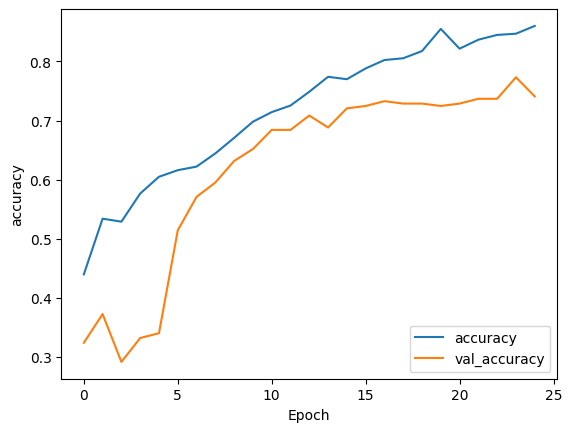

In [24]:
show_performance_curve(history, 'accuracy', 'accuracy')

In [48]:
#history.history['val_accuracy'][25]
history.history['accuracy'][25]

0.8581907153129578

[0.4399999976158142, 0.6843373775482178, 0.7260981798171997, 0.7482993006706238, 0.7852997779846191, 0.8007662892341614, 0.8366972208023071, 0.8151125311851501, 0.8446909785270691, 0.8519637584686279, 0.8581662178039551, 0.8488528728485107, 0.8548168540000916, 0.8883116841316223, 0.90234375, 0.878940761089325, 0.8888888955116272, 0.9031862616539001, 0.901190459728241, 0.9230769276618958, 0.8839080333709717, 0.9018265008926392, 0.9135944843292236, 0.9236031770706177, 0.9149888157844543]
[0.3238866329193115, 0.39772728085517883, 0.5454545617103577, 0.800000011920929, 0.6470588445663452, 0.6904761791229248, 0.8615384697914124, 0.8505747318267822, 0.8207547068595886, 0.8153846263885498, 0.8120300769805908, 0.7816901206970215, 0.8527131676673889, 0.7816091775894165, 0.7988165616989136, 0.800000011920929, 0.7908163070678711, 0.7680412530899048, 0.7772276997566223, 0.7660550475120544, 0.767123281955719, 0.7808219194412231, 0.77625572681427, 0.7962962985038757, 0.7828054428100586]


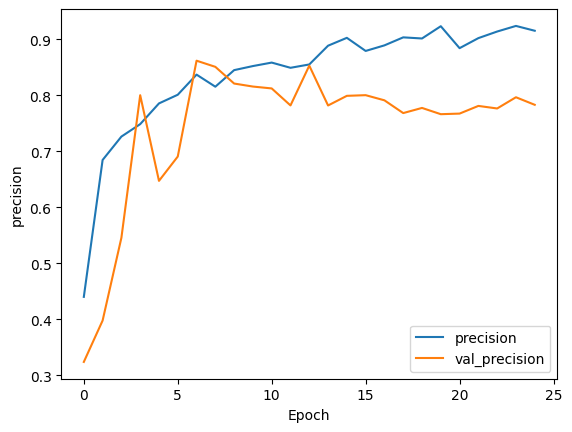

In [25]:
show_performance_curve(history, 'precision', 'precision')

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step


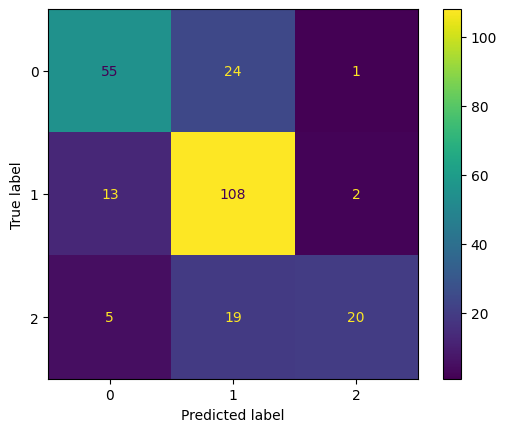

In [26]:
test_predictions = model.predict(X_test)

test_predicted_labels = np.argmax(test_predictions, axis=1)

test_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

In [28]:
# cambios en el modelo para evitar overfitting:
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model2 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model2.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model2.summary()

history2 = model2.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 67, 56, 40, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 33, 28, 20, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 33, 28, 20, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 33, 28, 20, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 16, 14, 10, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 14, 10, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 71680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,587,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,605,555 (17.57 MB)

 Trainable params: 4,605,443 (17.57 MB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.4104 - loss: 2.3674 - precision: 0.4097 - recall: 0.3646 - val_accuracy: 0.3239 - val_loss: 14.2243 - val_precision: 0.3239 - val_recall: 0.3239
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5759 - loss: 1.3300 - precision: 0.6589 - recall: 0.4312 - val_accuracy: 0.3239 - val_loss: 3.6988 - val_precision: 0.3093 - val_recall: 0.2955
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.6509 - loss: 0.8605 - precision: 0.7819 - recall: 0.4769 - val_accuracy: 0.2996 - val_loss: 2.2039 - val_precision: 0.3355 - val_recall: 0.2105
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.6966 - loss: 0.6790 - precision: 0.7822 - recall: 0.5715 - val_accuracy: 0.5304 - val_loss: 1.0906 - val_precision: 0.6667 - val_recall: 0.2510
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7713 - loss: 0.5451 - precision: 0.8790 - recall: 0.6576 - val_accuracy: 0.6194 - val_loss: 0.8890 -

[0.46504560112953186, 0.567375898361206, 0.6372846961021423, 0.6849037408828735, 0.7639310956001282, 0.783181369304657, 0.8419452905654907, 0.8774062991142273, 0.8936170339584351, 0.9027355909347534, 0.9280648231506348, 0.9412360787391663, 0.9483282566070557, 0.9503546357154846, 0.9483282566070557, 0.9604862928390503, 0.9706180095672607, 0.9696048498153687, 0.9726443886756897, 0.978723406791687, 0.9817629456520081, 0.9777102470397949, 0.9797365665435791, 0.9908814430236816, 0.9878419637680054]
[0.3238866329193115, 0.3238866329193115, 0.2995951473712921, 0.5303643941879272, 0.6194332242012024, 0.6882591247558594, 0.7449392676353455, 0.7449392676353455, 0.7530364394187927, 0.7773279547691345, 0.7692307829856873, 0.76113361120224, 0.7894737124443054, 0.7894737124443054, 0.7692307829856873, 0.76113361120224, 0.7773279547691345, 0.7692307829856873, 0.76113361120224, 0.76113361120224, 0.7732793688774109, 0.7489878535270691, 0.7773279547691345, 0.7813765406608582, 0.76113361120224]


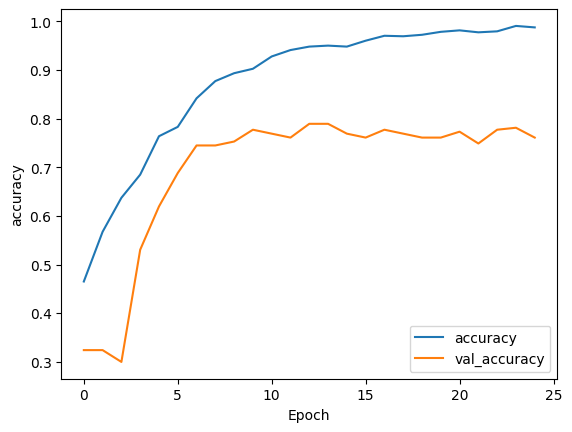

In [30]:
show_performance_curve(history2, 'accuracy', 'accuracy')

[0.4399999976158142, 0.6843373775482178, 0.7260981798171997, 0.7482993006706238, 0.7852997779846191, 0.8007662892341614, 0.8366972208023071, 0.8151125311851501, 0.8446909785270691, 0.8519637584686279, 0.8581662178039551, 0.8488528728485107, 0.8548168540000916, 0.8883116841316223, 0.90234375, 0.878940761089325, 0.8888888955116272, 0.9031862616539001, 0.901190459728241, 0.9230769276618958, 0.8839080333709717, 0.9018265008926392, 0.9135944843292236, 0.9236031770706177, 0.9149888157844543]
[0.3238866329193115, 0.39772728085517883, 0.5454545617103577, 0.800000011920929, 0.6470588445663452, 0.6904761791229248, 0.8615384697914124, 0.8505747318267822, 0.8207547068595886, 0.8153846263885498, 0.8120300769805908, 0.7816901206970215, 0.8527131676673889, 0.7816091775894165, 0.7988165616989136, 0.800000011920929, 0.7908163070678711, 0.7680412530899048, 0.7772276997566223, 0.7660550475120544, 0.767123281955719, 0.7808219194412231, 0.77625572681427, 0.7962962985038757, 0.7828054428100586]


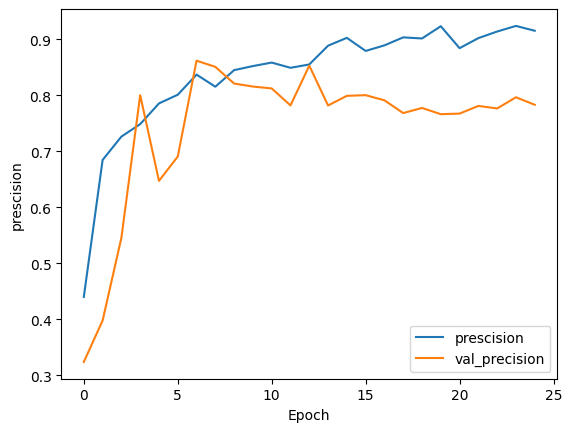

In [ ]:
show_performance_curve(history2, 'precision', 'prescision')

In [27]:
from tensorflow.keras.regularizers import l2

# modelo con l2 regularization
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model3 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model3.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model3.summary()

history3 = model3.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 67, 56, 40, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 33, 28, 20, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 33, 28, 20, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 33, 28, 20, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 16, 14, 10, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 14, 10, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 71680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,587,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,605,555 (17.57 MB)

 Trainable params: 4,605,443 (17.57 MB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.4864 - loss: 2.4455 - precision: 0.4967 - recall: 0.4438 - val_accuracy: 0.5061 - val_loss: 3.0474 - val_precision: 0.5061 - val_recall: 0.5020
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5720 - loss: 1.3532 - precision: 0.6290 - recall: 0.4066 - val_accuracy: 0.3644 - val_loss: 1.4482 - val_precision: 0.3762 - val_recall: 0.1538
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.6384 - loss: 0.9479 - precision: 0.7449 - recall: 0.5000 - val_accuracy: 0.3644 - val_loss: 1.3092 - val_precision: 0.4091 - val_recall: 0.0729
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.7279 - loss: 0.7397 - precision: 0.8143 - recall: 0.6366 - val_accuracy: 0.4980 - val_loss: 1.2510 - val_precision: 0.4792 - val_recall: 0.0931
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.7545 - loss: 0.7084 - precision: 0.8202 - recall: 0.6672 - val_accuracy: 0.5385 - val_loss: 1.1636 - val

[0.49949342012405396, 0.5754812359809875, 0.6616008281707764, 0.7355623245239258, 0.761904776096344, 0.8004052639007568, 0.848024308681488, 0.8794326186180115, 0.8733536005020142, 0.9098277688026428, 0.9260385036468506, 0.9321175217628479, 0.9533941149711609, 0.9452887773513794, 0.9564336538314819, 0.9625126719474792, 0.9655521512031555, 0.9675785303115845, 0.9766970872879028, 0.9817629456520081, 0.9848024249076843, 0.9807497262954712, 0.9858155846595764, 0.978723406791687, 0.9837892651557922]
[0.5060728788375854, 0.36437246203422546, 0.36437246203422546, 0.4979757070541382, 0.5384615659713745, 0.659919023513794, 0.6639676094055176, 0.7085019946098328, 0.7206477522850037, 0.7287449240684509, 0.7570850253105164, 0.7408906817436218, 0.7732793688774109, 0.7570850253105164, 0.76113361120224, 0.7651821970939636, 0.7813765406608582, 0.7732793688774109, 0.7570850253105164, 0.7813765406608582, 0.7570850253105164, 0.7773279547691345, 0.7570850253105164, 0.7651821970939636, 0.7854251265525818]


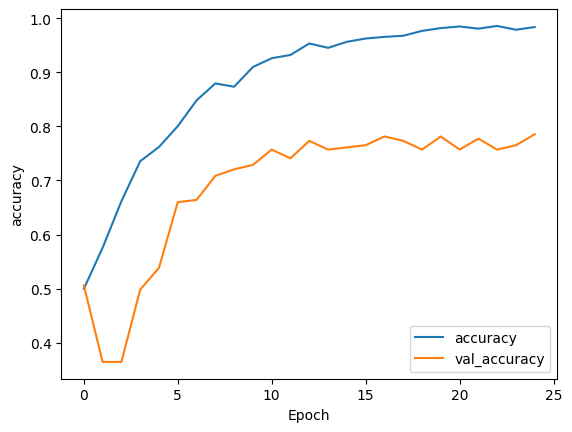

In [30]:
show_performance_curve(history3, 'accuracy', 'accuracy')

[0.5110851526260376, 0.6482084393501282, 0.7679389119148254, 0.8143405914306641, 0.8272058963775635, 0.8620689511299133, 0.9020978808403015, 0.9169472455978394, 0.911308228969574, 0.9446253776550293, 0.943736732006073, 0.949999988079071, 0.9624608755111694, 0.9592902064323425, 0.966701328754425, 0.9702258706092834, 0.975180983543396, 0.9743062853813171, 0.9825997948646545, 0.9836400747299194, 0.9877800345420837, 0.9826883673667908, 0.9877551198005676, 0.9826353192329407, 0.9866939783096313]
[0.5061224699020386, 0.3762376308441162, 0.40909090638160706, 0.4791666567325592, 0.6499999761581421, 0.8428571224212646, 0.8791208863258362, 0.811188817024231, 0.8541666865348816, 0.8108108043670654, 0.8387096524238586, 0.8067632913589478, 0.8252426981925964, 0.8082191944122314, 0.7990867495536804, 0.7937219738960266, 0.8105726838111877, 0.7965368032455444, 0.7659574747085571, 0.7922077775001526, 0.7676348686218262, 0.7931034564971924, 0.7573221921920776, 0.7773109078407288, 0.7782427072525024]


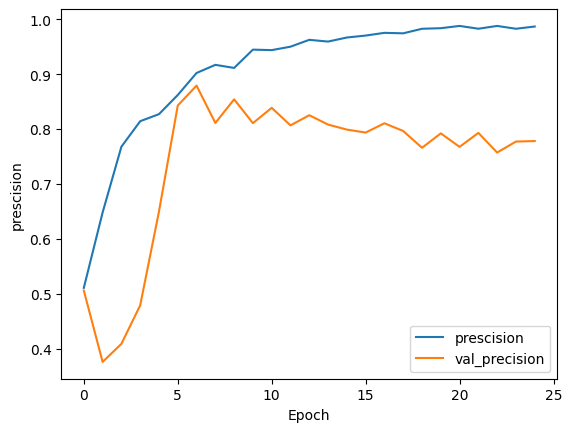

In [31]:
show_performance_curve(history3, 'precision', 'prescision')

In [32]:
from tensorflow.keras.regularizers import l2

# modelo con l2 regularization en todas las capas conv3d
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model4 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model4.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model4.summary()

history4 = model4.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)               │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 67, 56, 40, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 33, 28, 20, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 33, 28, 20, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 33, 28, 20, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 16, 14, 10, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 14, 10, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 71680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     4,587,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,605,555 (17.57 MB)

 Trainable params: 4,605,443 (17.57 MB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.4256 - loss: 2.1277 - precision: 0.4292 - recall: 0.3787 - val_accuracy: 0.3239 - val_loss: 9.9456 - val_precision: 0.3239 - val_recall: 0.3239
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.6016 - loss: 1.2135 - precision: 0.6962 - recall: 0.3765 - val_accuracy: 0.4453 - val_loss: 1.8240 - val_precision: 0.4645 - val_recall: 0.3968
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6663 - loss: 0.9621 - precision: 0.7806 - recall: 0.5032 - val_accuracy: 0.3158 - val_loss: 1.4463 - val_precision: 0.2941 - val_recall: 0.1822
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - accuracy: 0.7216 - loss: 0.8076 - precision: 0.8323 - recall: 0.5793 - val_accuracy: 0.4332 - val_loss: 1.2952 - val_precision: 0.4590 - val_recall: 0.2267
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.7655 - loss: 0.7045 - precision: 0.8460 - recall: 0.6862 - val_accuracy: 0.5385 - val_loss: 1.1336 - va

[0.4680851101875305, 0.5997973680496216, 0.6545085906982422, 0.7416413426399231, 0.7578520774841309, 0.8226950168609619, 0.8368794322013855, 0.8753799200057983, 0.8946301937103271, 0.8966565132141113, 0.9229989647865295, 0.9321175217628479, 0.9452887773513794, 0.9463019371032715, 0.9584599733352661, 0.954407274723053, 0.9645389914512634, 0.9655521512031555, 0.9675785303115845, 0.9696048498153687, 0.9716312289237976, 0.9655521512031555, 0.9848024249076843, 0.9766970872879028, 0.9766970872879028]
[0.3238866329193115, 0.44534412026405334, 0.31578946113586426, 0.43319839239120483, 0.5384615659713745, 0.6194332242012024, 0.6032388806343079, 0.659919023513794, 0.6882591247558594, 0.7287449240684509, 0.7085019946098328, 0.7125505805015564, 0.7287449240684509, 0.7287449240684509, 0.7368420958518982, 0.7327935099601746, 0.7327935099601746, 0.7408906817436218, 0.7408906817436218, 0.7651821970939636, 0.7651821970939636, 0.7570850253105164, 0.76113361120224, 0.7813765406608582, 0.7570850253105164]

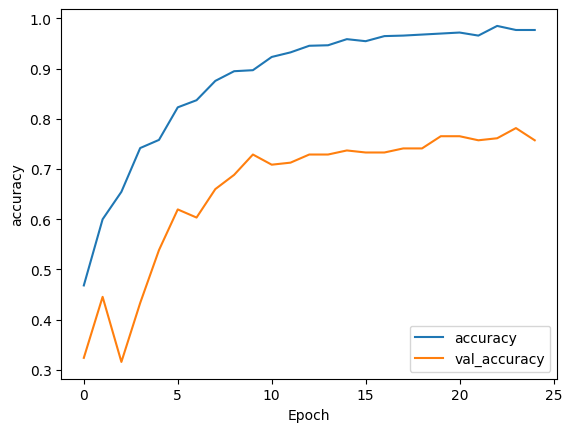

In [33]:
show_performance_curve(history4, 'accuracy', 'accuracy')

In [34]:
from tensorflow.keras.regularizers import l2

# modelo con l2 regularization en todas las capas conv3d y reduccion de filtros
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model5 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(12, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model5.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model5.summary()

history5 = model5.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 67, 56, 40, 12) │         2,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 33, 28, 20, 12) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 33, 28, 20, 12) │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 33, 28, 20, 16) │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 16, 14, 10, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 14, 10, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     2,293,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,302,191 (8.78 MB)

 Trainable params: 2,302,119 (8.78 MB)

 Non-trainable params: 72 (288.00 B)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.4708 - loss: 1.7742 - precision: 0.4770 - recall: 0.4018 - val_accuracy: 0.3239 - val_loss: 6.2151 - val_precision: 0.3252 - val_recall: 0.3239
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.6056 - loss: 1.0844 - precision: 0.6707 - recall: 0.4759 - val_accuracy: 0.3522 - val_loss: 2.1675 - val_precision: 0.3632 - val_recall: 0.3279
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.7188 - loss: 0.8523 - precision: 0.7947 - recall: 0.5934 - val_accuracy: 0.3198 - val_loss: 1.5394 - val_precision: 0.3040 - val_recall: 0.1538
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7754 - loss: 0.7210 - precision: 0.8300 - recall: 0.6663 - val_accuracy: 0.4170 - val_loss: 1.2849 - val_precision: 0.3821 - val_recall: 0.1903
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8194 - loss: 0.6149 - precision: 0.8674 - recall: 0.7379 - val_accuracy: 0.5304 - val_loss: 1.2035 - v

[0.47922998666763306, 0.6160081028938293, 0.719351589679718, 0.781154990196228, 0.8277608752250671, 0.8672745823860168, 0.8946301937103271, 0.9189463257789612, 0.9442755579948425, 0.9392096996307373, 0.9452887773513794, 0.9584599733352661, 0.9665653705596924, 0.975683867931366, 0.9766970872879028, 0.978723406791687, 0.9868287444114685, 0.9888551235198975, 0.9878419637680054, 0.9848024249076843, 0.9868287444114685, 0.9878419637680054, 0.9918946027755737, 0.9939209818840027, 0.9868287444114685]
[0.3238866329193115, 0.35222673416137695, 0.3198380470275879, 0.4170040488243103, 0.5303643941879272, 0.6275303363800049, 0.7004048824310303, 0.6963562965393066, 0.7246963381767273, 0.7368420958518982, 0.7408906817436218, 0.7489878535270691, 0.7489878535270691, 0.7854251265525818, 0.76113361120224, 0.7489878535270691, 0.7692307829856873, 0.7813765406608582, 0.7894737124443054, 0.7854251265525818, 0.8056679964065552, 0.7813765406608582, 0.7773279547691345, 0.7651821970939636, 0.7692307829856873]


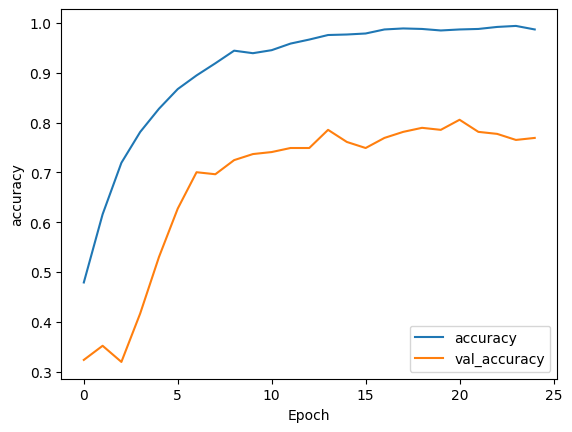

In [36]:
show_performance_curve(history5, 'accuracy', 'accuracy')

In [37]:
from tensorflow.keras.regularizers import l2

# modelo con l2 regularization en todas las capas conv3d y reduccion de filtros
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model6 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(12, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model6.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model6.summary()

history6 = model6.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_15 (Conv3D)              │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_16 (Conv3D)              │ (None, 67, 56, 40, 12) │         2,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 33, 28, 20, 12) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 33, 28, 20, 12) │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 33, 28, 20, 16) │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 16, 14, 10, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 14, 10, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     2,293,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,304,175 (8.79 MB)

 Trainable params: 2,304,103 (8.79 MB)

 Non-trainable params: 72 (288.00 B)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - accuracy: 0.4032 - loss: 1.8609 - precision: 0.3957 - recall: 0.3157 - val_accuracy: 0.2186 - val_loss: 3.7918 - val_precision: 0.2143 - val_recall: 0.2065
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.4716 - loss: 1.4431 - precision: 0.5068 - recall: 0.3869 - val_accuracy: 0.3360 - val_loss: 1.4917 - val_precision: 0.3699 - val_recall: 0.1093
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.5226 - loss: 1.2341 - precision: 0.5893 - recall: 0.3806 - val_accuracy: 0.2227 - val_loss: 1.5509 - val_precision: 0.1695 - val_recall: 0.0405
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.5227 - loss: 1.1679 - precision: 0.6188 - recall: 0.3786 - val_accuracy: 0.3198 - val_loss: 1.5889 - val_precision: 0.1509 - val_recall: 0.0324
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.5871 - loss: 1.0784 - precision: 0.6965 - recall: 0.4115 - val_accuracy: 0.3846 - val_loss: 1.3153 - 

[0.435663640499115, 0.47922998666763306, 0.5197568535804749, 0.5349544286727905, 0.5805470943450928, 0.6220871210098267, 0.6261398196220398, 0.6605876684188843, 0.6849037408828735, 0.6798378825187683, 0.7274569272994995, 0.7416413426399231, 0.73758864402771, 0.7477203607559204, 0.7963525652885437, 0.8064842820167542, 0.8237082362174988, 0.7953394055366516, 0.8186423778533936, 0.8216818571090698, 0.847011148929596, 0.8551164865493774, 0.8591691851615906, 0.8581560254096985, 0.8723404407501221]
[0.21862348914146423, 0.3360323905944824, 0.22267206013202667, 0.3198380470275879, 0.38461539149284363, 0.4898785352706909, 0.5303643941879272, 0.6194332242012024, 0.6356275081634521, 0.6639676094055176, 0.6558704376220703, 0.659919023513794, 0.6842105388641357, 0.6963562965393066, 0.692307710647583, 0.6963562965393066, 0.6842105388641357, 0.7287449240684509, 0.7246963381767273, 0.7125505805015564, 0.7449392676353455, 0.76113361120224, 0.7530364394187927, 0.7489878535270691, 0.7368420958518982]


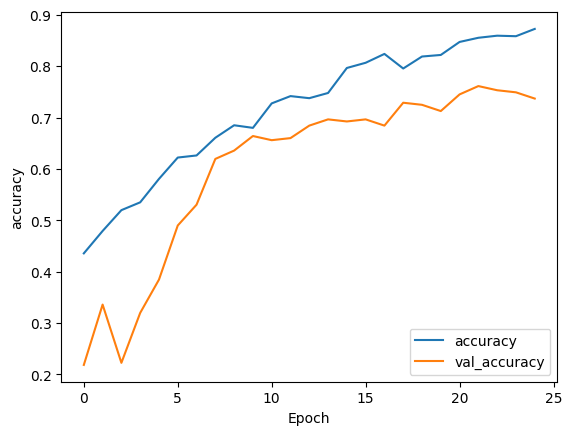

In [38]:
show_performance_curve(history6, 'accuracy', 'accuracy')

In [45]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# modelo con l2 regularization en todas las capas conv3d y reduccion de filtros
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model7 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(12, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model7.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model7.summary()

history7 = model7.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks = callbacks
)

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_21 (Conv3D)              │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_21 (MaxPooling3D) │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_22 (Conv3D)              │ (None, 67, 56, 40, 12) │         2,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_22 (MaxPooling3D) │ (None, 33, 28, 20, 12) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 33, 28, 20, 12) │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_23 (Conv3D)              │ (None, 33, 28, 20, 16) │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_23 (MaxPooling3D) │ (None, 16, 14, 10, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 14, 10, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │     2,293,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,302,191 (8.78 MB)

 Trainable params: 2,302,119 (8.78 MB)

 Non-trainable params: 72 (288.00 B)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.4062 - loss: 1.9542 - precision: 0.4028 - recall: 0.3694 - val_accuracy: 0.5182 - val_loss: 2.9901 - val_precision: 0.5228 - val_recall: 0.5101 - learning_rate: 1.0000e-04
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.5603 - loss: 1.2633 - precision: 0.6140 - recall: 0.3821 - val_accuracy: 0.2186 - val_loss: 3.6879 - val_precision: 0.2083 - val_recall: 0.2024 - learning_rate: 1.0000e-04
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.6561 - loss: 0.9186 - precision: 0.7357 - recall: 0.5510 - val_accuracy: 0.3279 - val_loss: 2.0416 - val_precision: 0.3023 - val_recall: 0.2105 - learning_rate: 1.0000e-04
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7208 - loss: 0.7491 - precision: 0.7982 - recall: 0.6541 - val_accuracy: 0.3927 - val_loss: 1.5027 - val_precision: 0.3554 - val_recall: 0.2389 - learning_rate: 1.0000e-04
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - ac

[0.456940233707428, 0.5927051901817322, 0.6828774213790894, 0.7304964661598206, 0.802431583404541, 0.8632218837738037, 0.9047619104385376, 0.9260385036468506, 0.9483282566070557, 0.9665653705596924, 0.978723406791687, 0.9868287444114685, 0.9797365665435791, 0.9868287444114685, 0.9929078221321106, 0.9908814430236816, 0.9939209818840027, 0.9939209818840027, 0.9949341416358948, 0.9989868402481079, 0.9949341416358948, 0.996960461139679, 0.996960461139679, 1.0, 0.9989868402481079]
[0.5182186365127563, 0.21862348914146423, 0.32793521881103516, 0.3927125632762909, 0.5587044358253479, 0.49392712116241455, 0.6437246799468994, 0.6882591247558594, 0.71659916639328, 0.7206477522850037, 0.7206477522850037, 0.71659916639328, 0.7327935099601746, 0.7327935099601746, 0.7489878535270691, 0.7530364394187927, 0.7530364394187927, 0.76113361120224, 0.76113361120224, 0.7773279547691345, 0.8056679964065552, 0.7732793688774109, 0.7651821970939636, 0.7530364394187927, 0.7773279547691345]


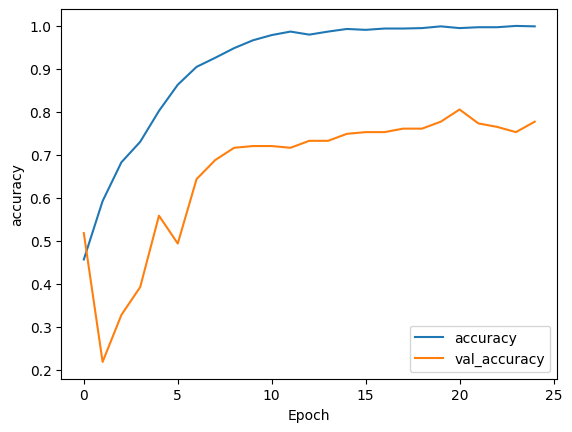

In [46]:
show_performance_curve(history7, 'accuracy', 'accuracy')

In [48]:
batch_size = 32
epochs = 25
num_classes = 3

In [49]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# modelo con l2 regularization en todas las capas conv3d y reduccion de filtros
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model8 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(12, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model8.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model8.summary()

history8 = model8.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks = callbacks
)

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)              │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_24 (MaxPooling3D) │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_25 (Conv3D)              │ (None, 67, 56, 40, 12) │         2,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_25 (MaxPooling3D) │ (None, 33, 28, 20, 12) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 33, 28, 20, 12) │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_26 (Conv3D)              │ (None, 33, 28, 20, 16) │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_26 (MaxPooling3D) │ (None, 16, 14, 10, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 14, 10, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │     2,293,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,302,191 (8.78 MB)

 Trainable params: 2,302,119 (8.78 MB)

 Non-trainable params: 72 (288.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4304 - loss: 1.7645 - precision: 0.4549 - recall: 0.3552 - val_accuracy: 0.3198 - val_loss: 3.0085 - val_precision: 0.3114 - val_recall: 0.2874 - learning_rate: 1.0000e-04
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5903 - loss: 1.2249 - precision: 0.6287 - recall: 0.4819 - val_accuracy: 0.4130 - val_loss: 1.5402 - val_precision: 0.4679 - val_recall: 0.2955 - learning_rate: 1.0000e-04
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6701 - loss: 0.8732 - precision: 0.7296 - recall: 0.5539 - val_accuracy: 0.5830 - val_loss: 1.1564 - val_precision: 0.6271 - val_recall: 0.4494 - learning_rate: 1.0000e-04
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7658 - loss: 0.7012 - precision: 0.8038 - recall: 0.7085 - val_accuracy: 0.6275 - val_loss: 1.0827 - val_precision: 0.7024 - val_recall: 0.4777 - learning_rate: 1.0000e-04
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accu

[0.456940233707428, 0.5927051901817322, 0.6828774213790894, 0.7304964661598206, 0.802431583404541, 0.8632218837738037, 0.9047619104385376, 0.9260385036468506, 0.9483282566070557, 0.9665653705596924, 0.978723406791687, 0.9868287444114685, 0.9797365665435791, 0.9868287444114685, 0.9929078221321106, 0.9908814430236816, 0.9939209818840027, 0.9939209818840027, 0.9949341416358948, 0.9989868402481079, 0.9949341416358948, 0.996960461139679, 0.996960461139679, 1.0, 0.9989868402481079]
[0.5182186365127563, 0.21862348914146423, 0.32793521881103516, 0.3927125632762909, 0.5587044358253479, 0.49392712116241455, 0.6437246799468994, 0.6882591247558594, 0.71659916639328, 0.7206477522850037, 0.7206477522850037, 0.71659916639328, 0.7327935099601746, 0.7327935099601746, 0.7489878535270691, 0.7530364394187927, 0.7530364394187927, 0.76113361120224, 0.76113361120224, 0.7773279547691345, 0.8056679964065552, 0.7732793688774109, 0.7651821970939636, 0.7530364394187927, 0.7773279547691345]


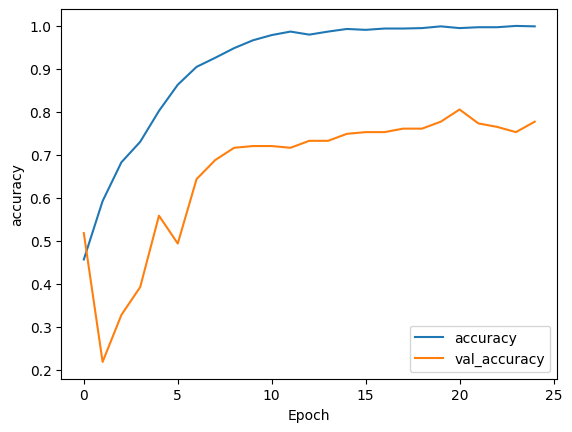

In [51]:
show_performance_curve(history7, 'accuracy', 'accuracy')

[0.4598214328289032, 0.6582278609275818, 0.7586206793785095, 0.798053503036499, 0.8428404927253723, 0.9029345512390137, 0.9349945783615112, 0.9457446932792664, 0.9663512110710144, 0.9713114500045776, 0.981500506401062, 0.9887410402297974, 0.9836734533309937, 0.9897959232330322, 0.9929006099700928, 0.9928644299507141, 0.994918704032898, 0.993914783000946, 0.9959431886672974, 0.9989868402481079, 0.9949341416358948, 0.996960461139679, 0.996960461139679, 1.0, 0.9989868402481079]
[0.5228216052055359, 0.2083333283662796, 0.302325576543808, 0.35542169213294983, 0.6461538672447205, 0.5207100510597229, 0.7407407164573669, 0.7512690424919128, 0.7635468244552612, 0.7534883618354797, 0.7616822719573975, 0.7455357313156128, 0.7652173638343811, 0.7662337422370911, 0.7739130258560181, 0.7627118825912476, 0.7659574747085571, 0.7698744535446167, 0.7634854912757874, 0.8025751113891602, 0.8170212507247925, 0.800000011920929, 0.7702127695083618, 0.7956521511077881, 0.8008658289909363]


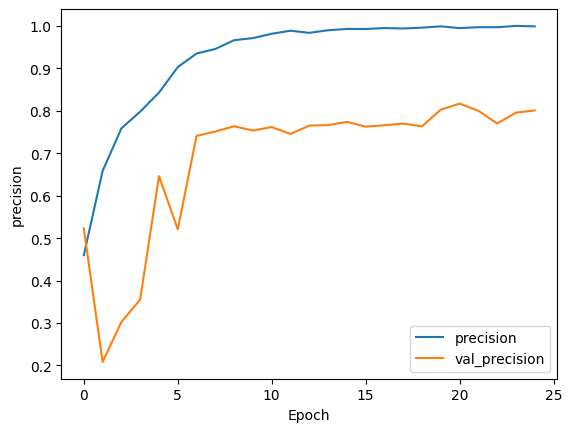

In [53]:
show_performance_curve(history7, 'precision', 'precision')

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step


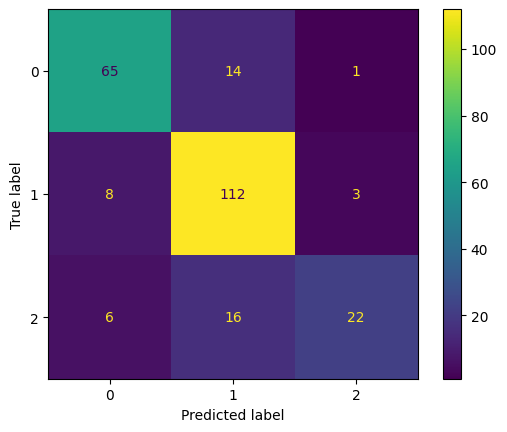

In [54]:
test_predictions = model7.predict(X_test)

test_predicted_labels = np.argmax(test_predictions, axis=1)

test_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step


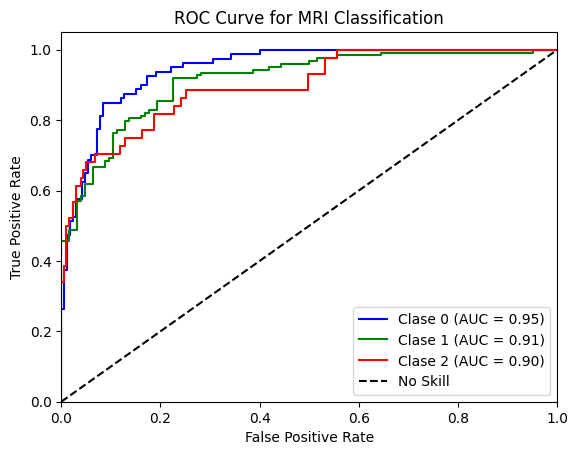

In [65]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model7.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred_proba[:,i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot the ROC curve
plt.figure() 
colors = ['blue', 'green', 'red']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MRI Classification')
plt.legend()
plt.show()

In [66]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# modelo con l2 regularization en todas las capas conv3d y reduccion de filtros
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model9 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(12, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model9.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model9.summary()

y_train_int = np.argmax(y_train, axis=1)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)

# Convertir a diccionario
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)



history9 = model9.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks = callbacks,
    class_weight=class_weight_dict
)

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_27 (Conv3D)              │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_28 (Conv3D)              │ (None, 67, 56, 40, 12) │         2,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_28 (MaxPooling3D) │ (None, 33, 28, 20, 12) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 33, 28, 20, 12) │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 33, 28, 20, 16) │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_29 (MaxPooling3D) │ (None, 16, 14, 10, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 14, 10, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │     2,293,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,302,191 (8.78 MB)

 Trainable params: 2,302,119 (8.78 MB)

 Non-trainable params: 72 (288.00 B)

{0: np.float64(0.9454022988505747), 1: np.float64(0.689727463312369), 2: np.float64(2.0308641975308643)}
Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.4078 - loss: 2.0967 - precision: 0.4249 - recall: 0.3379 - val_accuracy: 0.3077 - val_loss: 1.6610 - val_precision: 0.2949 - val_recall: 0.1862 - learning_rate: 1.0000e-04
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5999 - loss: 1.0856 - precision: 0.6937 - recall: 0.3507 - val_accuracy: 0.4170 - val_loss: 1.3193 - val_precision: 0.4959 - val_recall: 0.2429 - learning_rate: 1.0000e-04
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6768 - loss: 0.8802 - precision: 0.7485 - recall: 0.5554 - val_accuracy: 0.5061 - val_loss: 1.2258 - val_precision: 0.6739 - val_recall: 0.2510 - learning_rate: 1.0000e-04
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7884 - loss: 0.6576 - precision: 0.8519 - recall: 0.7108 - val_accuracy: 0.7045 - val_loss: 0.9197 - val_precision: 0.8406 

[0.41742655634880066, 0.631205677986145, 0.6859169006347656, 0.7922999262809753, 0.8784194588661194, 0.9250253438949585, 0.9452887773513794, 0.975683867931366, 0.9868287444114685, 0.9817629456520081, 0.9959473013877869, 0.9929078221321106, 0.9959473013877869, 0.996960461139679, 0.9959473013877869]
[0.3076923191547394, 0.4170040488243103, 0.5060728788375854, 0.7044534683227539, 0.7206477522850037, 0.7206477522850037, 0.7570850253105164, 0.7894737124443054, 0.7773279547691345, 0.8056679964065552, 0.7894737124443054, 0.7813765406608582, 0.7813765406608582, 0.7854251265525818, 0.7813765406608582]


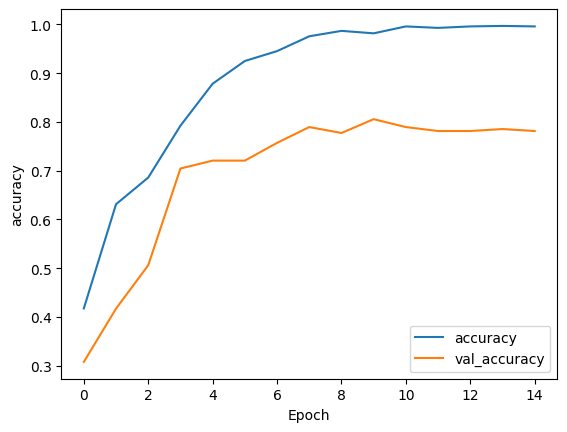

In [68]:
show_performance_curve(history9, 'accuracy', 'accuracy')

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step


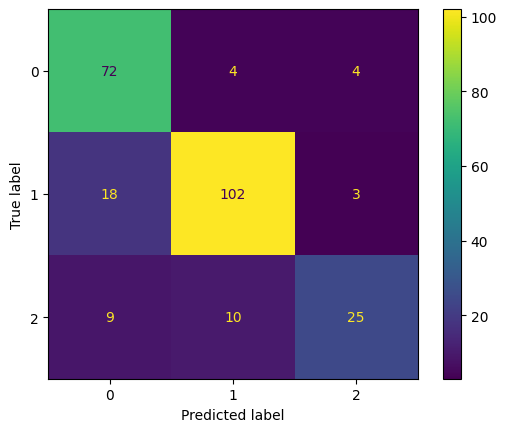

In [69]:
test_predictions = model9.predict(X_test)

test_predicted_labels = np.argmax(test_predictions, axis=1)

test_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step


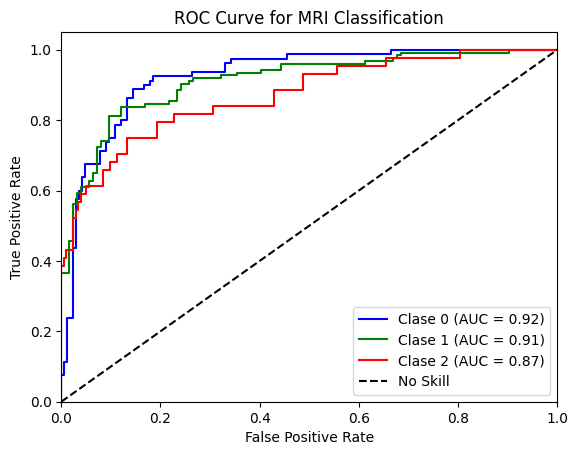

In [71]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model9.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred_proba[:,i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot the ROC curve
plt.figure() 
colors = ['blue', 'green', 'red']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MRI Classification')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [ 
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# modelo con l2 regularization en todas las capas conv3d y reduccion de filtros
input_shape = X_train.shape[1:]  # (D, H, W, 1)

model10 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(12, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model10.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model10.summary()

y_train_int = np.argmax(y_train, axis=1)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)

# Convertir a diccionario
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)



history10 = model10.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks = callbacks,
    class_weight=class_weight_dict
)

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_30 (Conv3D)              │ (None, 135, 113, 81,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_30 (MaxPooling3D) │ (None, 67, 56, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 67, 56, 40, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 67, 56, 40, 12) │         2,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_31 (MaxPooling3D) │ (None, 33, 28, 20, 12) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 33, 28, 20, 12) │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_32 (Conv3D)              │ (None, 33, 28, 20, 16) │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_32 (MaxPooling3D) │ (None, 16, 14, 10, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 16, 14, 10, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │     2,293,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,304,175 (8.79 MB)

 Trainable params: 2,304,103 (8.79 MB)

 Non-trainable params: 72 (288.00 B)

{0: np.float64(0.9454022988505747), 1: np.float64(0.689727463312369), 2: np.float64(2.0308641975308643)}
Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4122 - loss: 2.1144 - precision: 0.4241 - recall: 0.3333 - val_accuracy: 0.3158 - val_loss: 3.0761 - val_precision: 0.3302 - val_recall: 0.2834 - learning_rate: 1.0000e-04
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4222 - loss: 1.4598 - precision: 0.4621 - recall: 0.2568 - val_accuracy: 0.2510 - val_loss: 1.5813 - val_precision: 0.2500 - val_recall: 0.0891 - learning_rate: 1.0000e-04
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4772 - loss: 1.3041 - precision: 0.5888 - recall: 0.3027 - val_accuracy: 0.4899 - val_loss: 1.2408 - val_precision: 0.5000 - val_recall: 0.0202 - learning_rate: 1.0000e-04
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5043 - loss: 1.1722 - precision: 0.6652 - recall: 0.3121 - val_accuracy: 0.4980 - val_loss: 1.2070 - val_precision: 0.8846 

In [110]:
# Prediccion de sujetos sin diagnóstico

nii_to_predict = not_found_1 + not_found_2 + not_found_3

# All are from not_found_1 therefore we are only looking into ADNI1 Yr1
init_dir = ["E:/ADNI1_Complete 1Yr 3T - processed"]
X = []
nii_order = []
cont = 0
for dir in init_dir:    
    for folder in os.listdir(dir):
        path = os.path.join(dir, folder)
        for file in os.listdir(path):
             if file.startswith("ADNI") and file.endswith(".nii"):
                nii_name = file
        
        if nii_name not in nii_to_predict: continue

        path = os.path.join(dir, folder, "cropped")
        left_path = os.path.join(path, "cropped_nii_left.nii")
        right_path = os.path.join(path, "cropped_nii_right.nii")

        left_nii = nib.load(left_path).get_fdata()
        right_nii = nib.load(right_path).get_fdata()            

        left_nii = left_nii[...,np.newaxis]
        right_nii = right_nii[...,np.newaxis]
        
        X.append(left_nii)
        X.append(right_nii)
        nii_order.append(folder)


In [112]:
X_predict = np.array(X)

In [113]:
X_predict.shape

(20, 135, 113, 81, 1)

In [117]:
nii_order

['subject59',
 'subject62',
 'subject80',
 'subject91',
 'subject97',
 'subject100',
 'subject102',
 'subject104',
 'subject106',
 'subject110']

In [116]:
# With all the subjects fond, now we predict the diagnosis for each subject
test_predictions = model7.predict(X_predict)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_predicted_labels.reshape(-1, 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


array([[0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1]])

In [65]:
# concatencacion por canal (se pasan las dos imágenes a la vez pero por separado - 2 imágenes - 2 canales)

input_shape = X_channels_train.shape[1:]  # (D, H, W, 2)

model2 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model2.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model2.summary()

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_30 (Conv3D)              │ (None, 129, 99, 105,   │           440 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_30 (MaxPooling3D) │ (None, 64, 49, 52, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64, 49, 52, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 64, 49, 52, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_31 (MaxPooling3D) │ (None, 32, 24, 26, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32, 24, 26, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_32 (Conv3D)              │ (None, 32, 24, 26, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_32 (MaxPooling3D) │ (None, 16, 12, 13, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 16, 12, 13, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 79872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     5,111,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,130,059 (19.57 MB)

 Trainable params: 5,129,947 (19.57 MB)

 Non-trainable params: 112 (448.00 B)

In [67]:
history2 = model2.fit(
    X_channels_train, y_channels_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_channels_test, y_channels_test),
    verbose=1
)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.3293 - loss: 2.5565 - precision: 0.3178 - recall: 0.2894 - val_accuracy: 0.4038 - val_loss: 23.8074 - val_precision: 0.4038 - val_recall: 0.4038
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.5043 - loss: 3.1703 - precision: 0.5348 - recall: 0.4765 - val_accuracy: 0.1538 - val_loss: 15.7029 - val_precision: 0.1538 - val_recall: 0.1538
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4919 - loss: 2.1770 - precision: 0.5205 - recall: 0.3944 - val_accuracy: 0.2885 - val_loss: 5.0623 - val_precision: 0.2941 - val_recall: 0.2885
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5632 - loss: 1.4041 - precision: 0.6140 - recall: 0.4152 - val_accuracy: 0.6538 - val_loss: 1.3915 - val_precision: 0.6800 - val_recall: 0.6538
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5433 - loss: 1.3948 - precision: 0.5902 - recall: 0.3725 - val_accuracy: 0.5192 - val_loss: 1.3031 - val_precisi

In [70]:
# concatenación espacial (se unen las imágenes creando un hipocampo completo - única imagen - 1 canal)
input_shape = X_whole_train.shape[1:]  # (D, H, W, 1)

model3 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model3.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model3.summary()

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_36 (Conv3D)              │ (None, 129, 99, 210,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_36 (MaxPooling3D) │ (None, 64, 49, 105, 8) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64, 49, 105, 8) │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_37 (Conv3D)              │ (None, 64, 49, 105,    │         3,472 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_37 (MaxPooling3D) │ (None, 32, 24, 52, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 24, 52, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_38 (Conv3D)              │ (None, 32, 24, 52, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_38 (MaxPooling3D) │ (None, 16, 12, 26, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 12, 26, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 159744)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │    10,223,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241,651 (39.07 MB)

 Trainable params: 10,241,539 (39.07 MB)

 Non-trainable params: 112 (448.00 B)

In [71]:
history3 = model3.fit(
    X_whole_train, y_whole_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_whole_test, y_whole_test),
    verbose=1
)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 134s 26s/step - accuracy: 0.3931 - loss: 3.8389 - precision: 0.3992 - recall: 0.3794 - val_accuracy: 0.4038 - val_loss: 27.1678 - val_precision: 0.4038 - val_recall: 0.4038
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 255s 66s/step - accuracy: 0.4288 - loss: 2.6684 - precision: 0.4525 - recall: 0.3786 - val_accuracy: 0.3462 - val_loss: 13.8410 - val_precision: 0.3462 - val_recall: 0.3462
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 338s 76s/step - accuracy: 0.5219 - loss: 1.7176 - precision: 0.5548 - recall: 0.3993 - val_accuracy: 0.1923 - val_loss: 8.8922 - val_precision: 0.1923 - val_recall: 0.1923
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 289s 63s/step - accuracy: 0.5286 - loss: 1.8035 - precision: 0.6336 - recall: 0.3050 - val_accuracy: 0.4423 - val_loss: 3.0964 - val_precision: 0.4423 - val_recall: 0.4423
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 363s 84s/step - accuracy: 0.5288 - loss: 1.8413 - precision: 0.7252 - recall: 0.3127 - val_accuracy: 0.5000 - val_loss: 2.3015 - v

In [38]:
# flipping right hippocmapus tu match left hipocmapus
# concatenación espacial (se unen las imágenes creando un hipocampo completo - única imagen - 1 canal)
input_shape = X_flipped_train.shape[1:]  # (D, H, W, 1)

model4 = Sequential([
    Conv3D(8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=2, strides=2), # Las imágenes tiene profundidad de 1
    BatchNormalization(),

    Conv3D(16, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Conv3D(32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling3D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax')  # ahora tiene 3 clases
])

model4.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')])
model4.summary()

c:\Users\Usuario\Documents\TFM - Chey\tfm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)               │ (None, 129, 99, 105,   │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 64, 49, 52, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 49, 52, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 64, 49, 52, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 32, 24, 26, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 24, 26, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 32, 24, 26, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 16, 12, 13, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 12, 13, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 79872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     5,111,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129,843 (19.57 MB)

 Trainable params: 5,129,731 (19.57 MB)

 Non-trainable params: 112 (448.00 B)

In [39]:
history4 = model4.fit(
    X_flipped_train, y_flipped_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_flipped_test, y_flipped_test),
    verbose=1
)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.3490 - loss: 2.5288 - precision: 0.3431 - recall: 0.3047 - val_accuracy: 0.5340 - val_loss: 5.6393 - val_precision: 0.5340 - val_recall: 0.5340
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.4537 - loss: 1.8308 - precision: 0.4449 - recall: 0.2954 - val_accuracy: 0.2816 - val_loss: 5.1025 - val_precision: 0.2816 - val_recall: 0.2816
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5265 - loss: 1.4731 - precision: 0.5298 - recall: 0.3004 - val_accuracy: 0.2816 - val_loss: 3.2420 - val_precision: 0.2843 - val_recall: 0.2816
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4862 - loss: 1.1645 - precision: 0.5686 - recall: 0.3030 - val_accuracy: 0.3689 - val_loss: 1.1162 - val_precision: 0.5556 - val_recall: 0.1942
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.5760 - loss: 0.9563 - precision: 0.7191 - recall: 0.3593 - val_accuracy: 0.4369 - val_loss: 1.0702 - val_precision

[0.38386309146881104, 0.4816626012325287, 0.5207824110984802, 0.5501222610473633, 0.5696821808815002, 0.6039119958877563, 0.5843520760536194, 0.6112469434738159, 0.616136908531189, 0.6625916957855225, 0.6674816608428955, 0.6552567481994629, 0.6430317759513855, 0.6748166084289551, 0.713936448097229, 0.6870415806770325, 0.7017114758491516, 0.7457212805747986, 0.7628361582756042, 0.7286063432693481, 0.7775061130523682, 0.7921760678291321, 0.8019559979438782, 0.8435207605361938, 0.7970660328865051]
[0.18446601927280426, 0.5145630836486816, 0.43689319491386414, 0.5631067752838135, 0.24271844327449799, 0.3300970792770386, 0.27184465527534485, 0.3106796145439148, 0.3203883469104767, 0.35922330617904663, 0.48543688654899597, 0.5922330021858215, 0.582524299621582, 0.5631067752838135, 0.6116504669189453, 0.6310679316520691, 0.5922330021858215, 0.6019417643547058, 0.6116504669189453, 0.6213592290878296, 0.5922330021858215, 0.5922330021858215, 0.6310679316520691, 0.6407766938209534, 0.669902920722

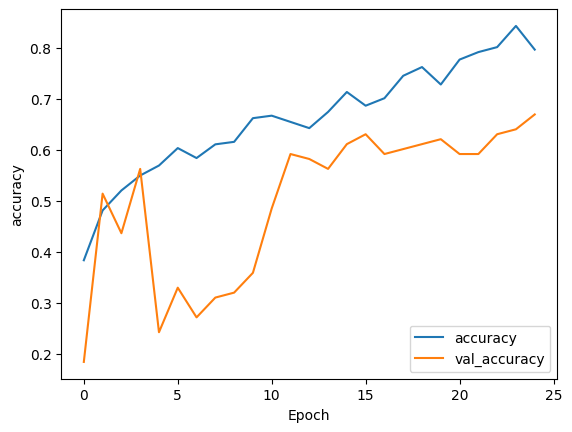

In [40]:
show_performance_curve(history, 'accuracy', 'accuracy')

[0.3790322542190552, 0.5029585957527161, 0.5403226017951965, 0.6710526347160339, 0.7414634227752686, 0.8341231942176819, 0.7753304243087769, 0.7644787430763245, 0.7662835121154785, 0.855967104434967, 0.8677042722702026, 0.8320610523223877, 0.8208954930305481, 0.8587360382080078, 0.9118773937225342, 0.8953068852424622, 0.8522336483001709, 0.899328887462616, 0.8827361464500427, 0.8621794581413269, 0.9271523356437683, 0.9218240976333618, 0.8849557638168335, 0.9144542813301086, 0.8855421543121338]
[0.18446601927280426, 0.5196078419685364, 0.4938271641731262, 0.6129032373428345, 0.1875, 0.125, 0.13636364042758942, 0.260869562625885, 0.3181818127632141, 0.3333333432674408, 0.5714285969734192, 0.6875, 0.8333333134651184, 0.692307710647583, 0.8181818127632141, 0.8529411554336548, 0.8285714387893677, 0.7291666865348816, 0.7777777910232544, 0.8113207817077637, 0.807692289352417, 0.7543859481811523, 0.8070175647735596, 0.761904776096344, 0.75]


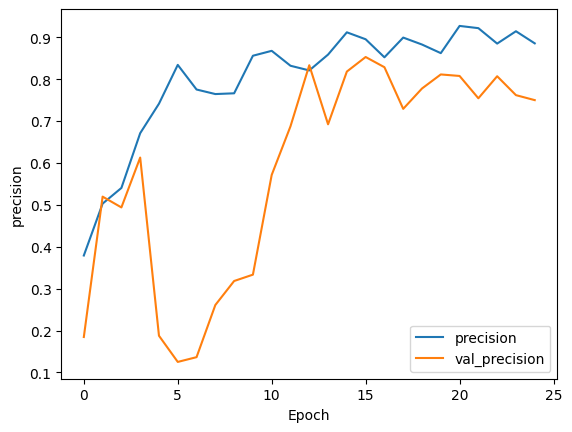

In [41]:
show_performance_curve(history, 'precision', 'precision')

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step


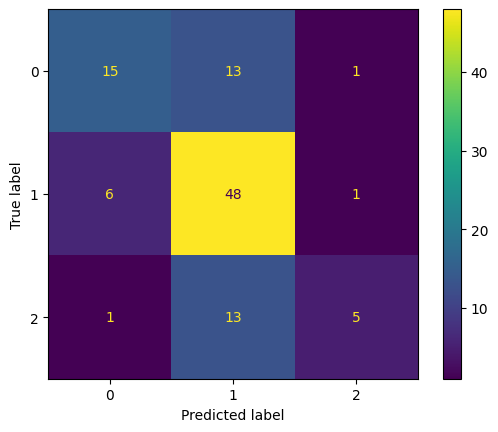

In [42]:
test_predictions = model4.predict(X_flipped_test)

test_predicted_labels = np.argmax(test_predictions, axis=1)

test_true_labels = np.argmax(y_flipped_test, axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()